# Incorporating Prior Information.

We will see how one can add prior information to method when it is known that some edges cannot exist between some nodes of the sparse graph. When performing cross-validation, one might also want to abort the computation of the path when the rank of the low-rank component reaches a given threshold.

This is a follow up on: https://github.com/benjaminfrot/lrpsadmm-examples/blob/master/sp500_example.ipynb .

## Example on synthetic data

Let us generate some artificial data and perform cross-validation while forcing some of the edges to 0.

In [13]:
library(lrpsadmm)

In [14]:
set.seed(0)
# Generate data for a well-powered dataset
sim.data <- generate.latent.ggm.data(n=2000, p=100, h=5, outlier.fraction = 0.0,
                                     sparsity = 0.02, sparsity.latent = 0.7)
X <- sim.data$obs.data; Sigma <- cor(X) # Sample correlation matrix

Let us use our knowledge of the true precision matrix. We force all the other entries to be equal to 0.
The sparsity patterns are very different. 

#Iter | Objfun | snorm | eps_dual | rnorm | eps_pri
0 | 99.966 | 0.381168 | 0.0100014 | 1.43792 | 0.0100103
#Iter | Objfun | snorm | eps_dual | rnorm | eps_pri
0 | 99.9755 | 0.384459 | 0.0100014 | 1.43197 | 0.0100103


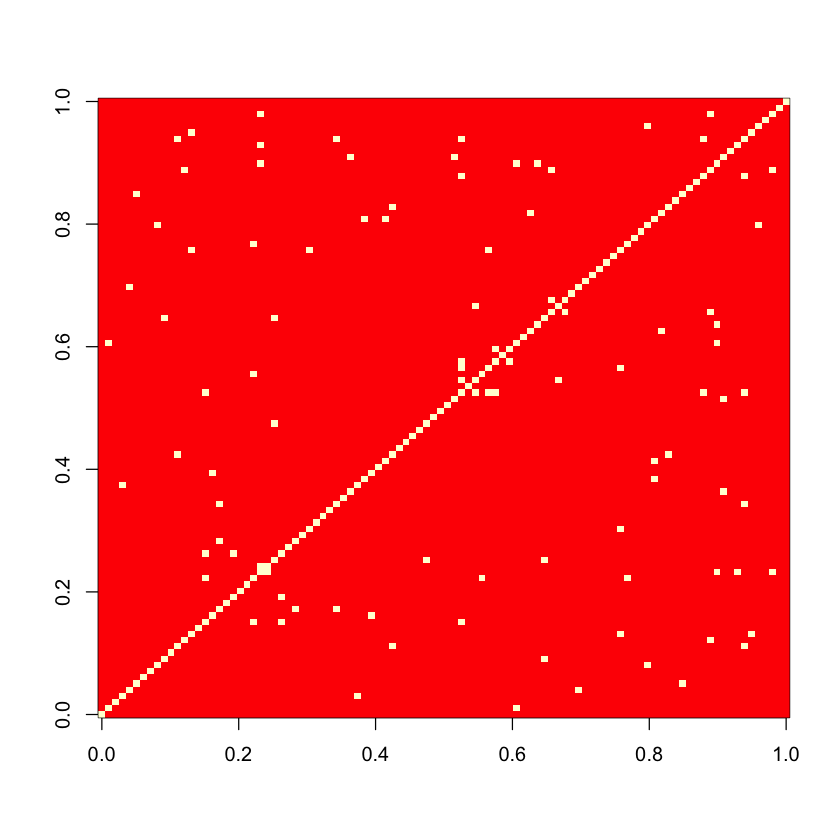

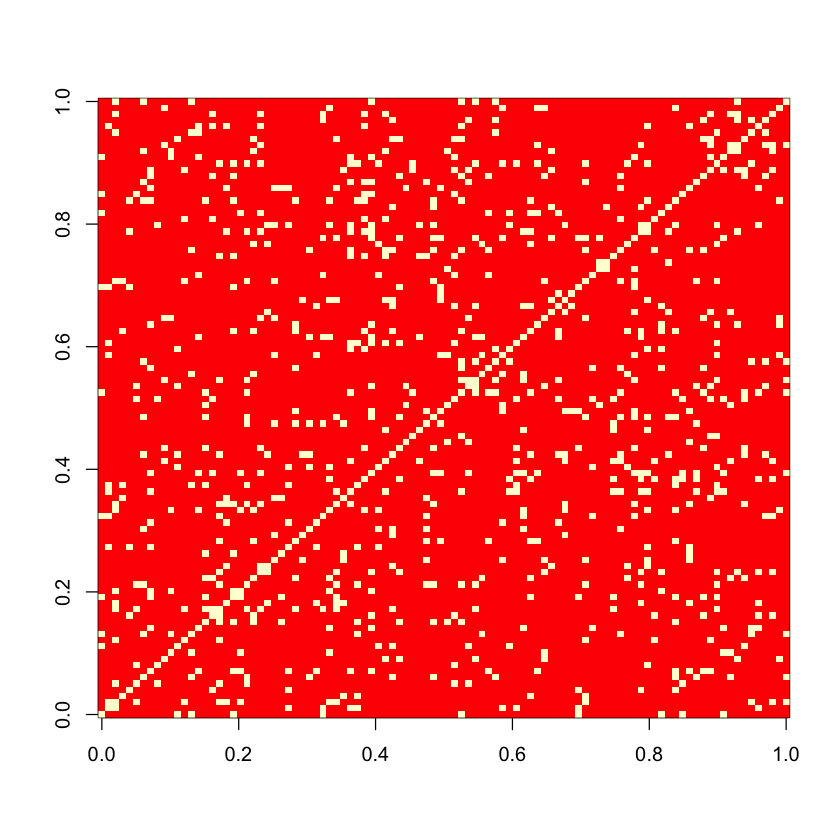

In [15]:
lambda <- 0.4; gamma <- 0.1 # Tuning Parameters
l1 <- lambda * gamma; l2 <- lambda * (1 - gamma)

### Force the sparsity pattern of the sparse component
zeros = 1 * (sim.data$precision.matrix != 0) # A mtrix of 0 and 1.
zeros = zeros[1:100,1:100] # Keep only the observed part
# Whereever zeros[i,j] = 0, the estimated S will be 0.
fit.zeros <- lrpsadmm(Sigma, l1, l2, zeros = zeros, abs_tol=1e-04, rel_tol = 1e-06)
fit.no.zeros <- lrpsadmm(Sigma, l1, l2, abs_tol=1e-04, rel_tol = 1e-06)
image(fit.zeros$S!=0) # Comparing the sparsity patterns
image(fit.no.zeros$S!=0)

We can also do this while performing cross-validation. We will also stop the computation of a path when the rank of L is too high. This should take ~ 15 seconds. Here we set `max.rank = 30`.

[1] "### Computing the path on the full dataset first ###"
[1] "Fitting with gamma= 0.05  and lambda= 7.52254880219212 Sparsity: 0 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 5.97537291067253 Sparsity: 0 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 4.7464074159538 Sparsity: 0 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 3.77020542399682 Sparsity: 0 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 2.99478061899131 Sparsity: 0.000202020202020202 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 2.37883880246985 Sparsity: 0.000606060606060606 Rank of L: 0"
[1] "Fitting with gamma= 0.05  and lambda= 1.8895788266595 Sparsity: 0.00242424242424242 Rank of L: 1"
[1] "Fitting with gamma= 0.05  and lambda= 1.50094581375282 Sparsity: 0.00585858585858586 Rank of L: 2"
[1] "Fitting with gamma= 0.05  and lambda= 1.19224363865508 Sparsity: 0.00808080808080808 Rank of L: 2"
[1] "Fitting with gamma= 0.05  and lambda= 0.947032784854144 Sparsity: 0.0098

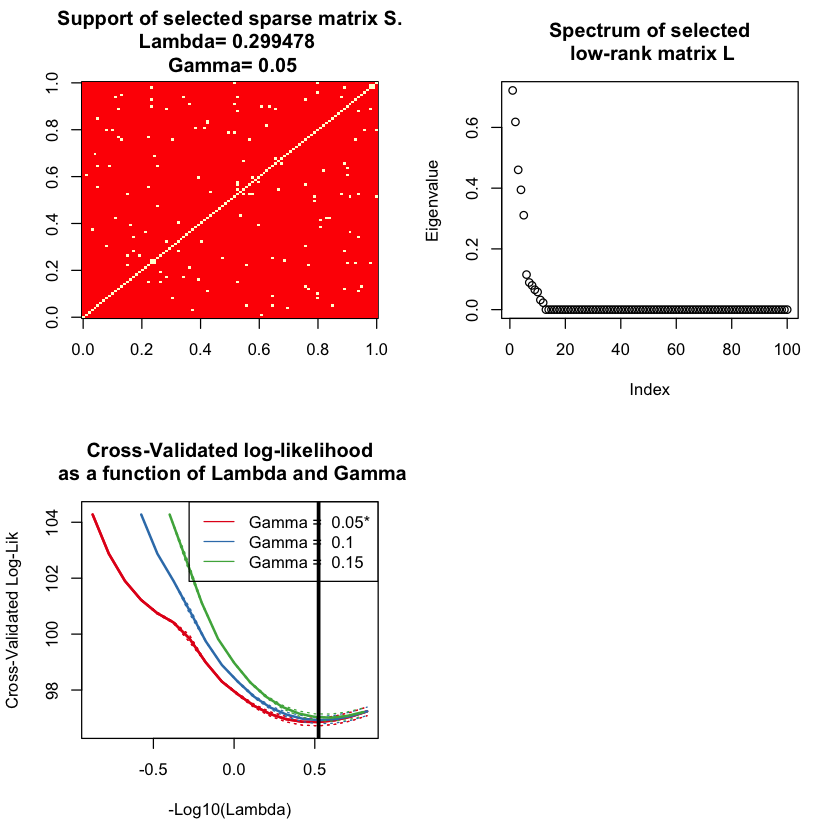

In [16]:
start_time <- Sys.time()
cv.zeros <- lrpsadmm.cv(X, zeros = zeros, n.folds = 3, max.rank = 30 ,verbose=TRUE, lambda.ratio = 1e-03, 
                        n.lambdas = 30)
end_time <- Sys.time()
print(end_time - start_time)
plot(cv.zeros)

In [17]:
print(paste("Lambda:", cv.zeros$best.fit$lambda, "Gamma:", cv.zeros$best.fit$gamma))
print(paste("Number of edges:", cv.zeros$best.fit$number.of.edges, "Rank of low-rank matrix:", cv.zeros$best.fit$rank.L))

[1] "Lambda: 0.299478061899131 Gamma: 0.05"
[1] "Number of edges: 68 Rank of low-rank matrix: 12"


If we plot the path for the selected value of gamma and the precision / recall curve, we see that the precision is always 1. This is because we restricted the support of the estimated S to its true support.

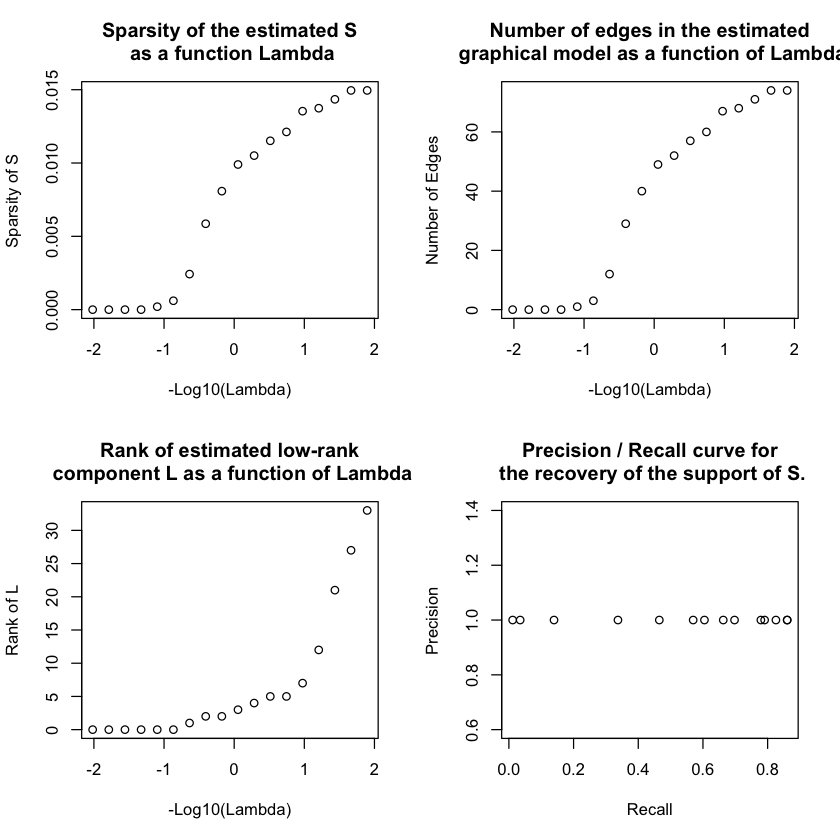

In [18]:
ground.truth <- sim.data$precision.matrix[1:100, 1:100]
# Remove the elements along the diagonal. Keep a matrix of 0s and 1s
ground.truth <- 1 * (( ground.truth - diag(diag(ground.truth)) ) !=0)
plot(cv.zeros$cross.validated.paths[[1]]$cross.validated.path, ground.truth = ground.truth)

Out of curiosity, let us compare this to what would would have happened had we not known the support.

Time difference of 18.29807 secs


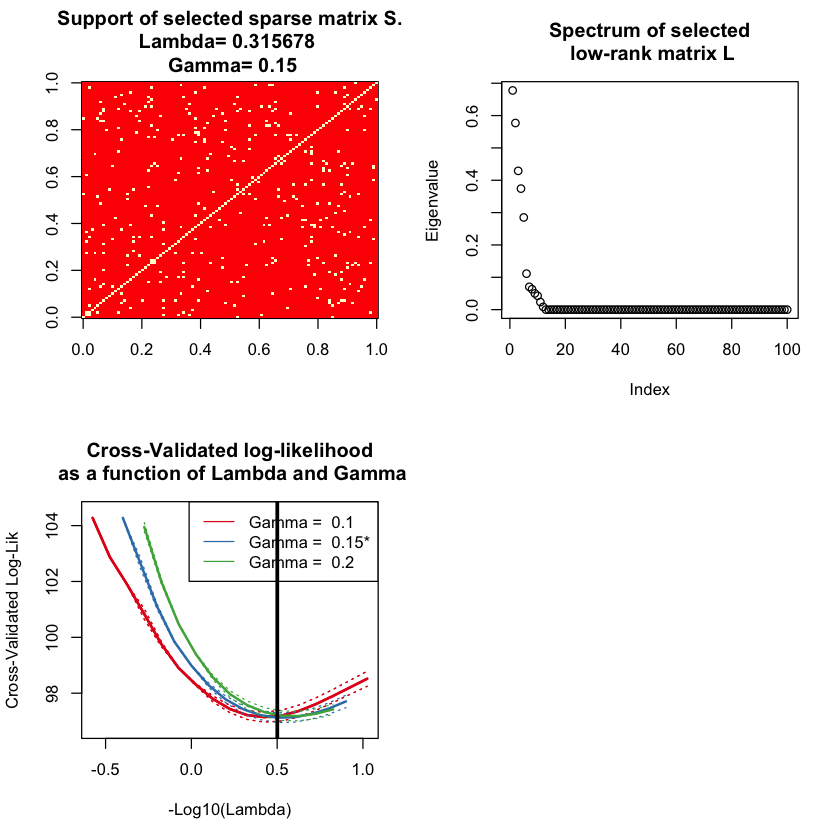

In [19]:
start_time <- Sys.time()
cv.no.zeros <- lrpsadmm.cv(X, n.folds = 3, gammas=c(0.1, 0.15, 0.2), max.rank = 30, lambda.ratio = 1e-03, 
                        n.lambdas = 30)
end_time <- Sys.time()
print(end_time - start_time)
plot(cv.no.zeros)

In [20]:
print(paste("Lambda:", cv.no.zeros$best.fit$lambda, "Gamma:", cv.no.zeros$best.fit$gamma))
print(paste("Number of edges:", cv.no.zeros$best.fit$number.of.edges, "Rank of low-rank matrix:", cv.no.zeros$best.fit$rank.L))

[1] "Lambda: 0.315677594951381 Gamma: 0.15"
[1] "Number of edges: 171 Rank of low-rank matrix: 12"


We can look at the precision/recall curve:

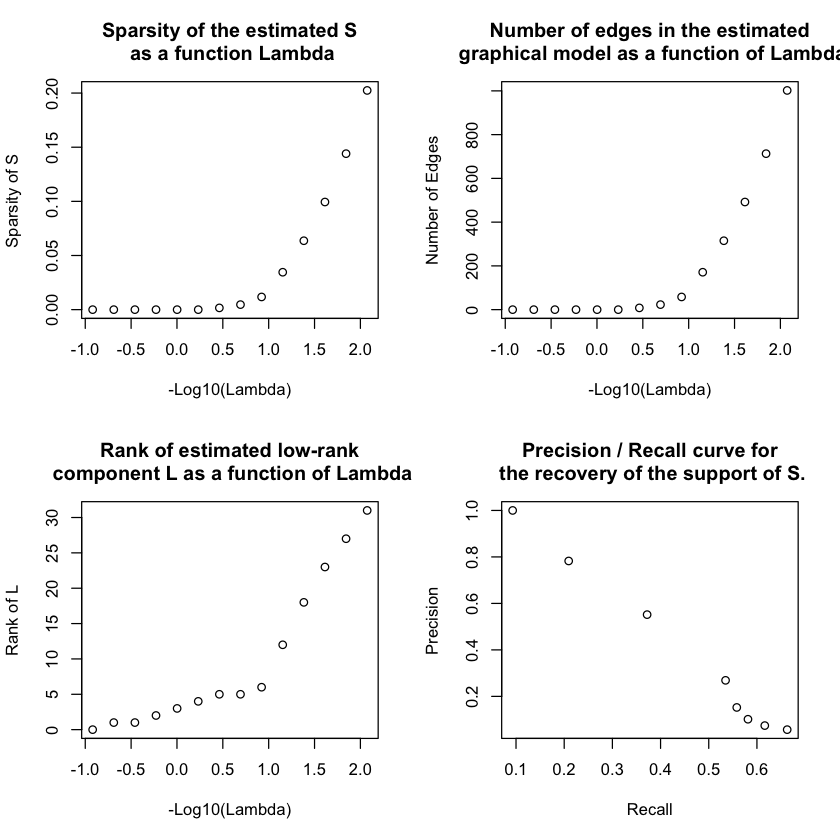

In [21]:
# Pick the second entry of the list because 0.15 was selected and it was the second value in c(0.1, 0.15, 0.2) 
plot(cv.no.zeros$cross.validated.paths[[2]]$cross.validated.path, ground.truth = ground.truth)